# Model Evaluation & Validation: Train Test Split

## Overview

<style>
    table.custom-table {
        max-width: 600px;
        width: 100%;
        margin: 0 auto; /* centers the table on the page */
    }

    table.custom-table td {
        background-color: #fff;
    }
    
    table.custom-table th, table.custom-table td {
        text-align: center;
        vertical-align: middle;
        padding: 5px;
        width: 600px; /* distribute the total width equally among three columns */
    }

    table.custom-table img {
        width: 100%;
        display: block; /* removes any gap under the image */
    }
</style>


<table class="custom-table">
    <thead>
        <tr>
            <th>Why is Train Test Split necessary?</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <img src="src/02_input.png">
            </td>
        </tr>
        <tr>
            <td>
                <img src="src/02_output_1.png">
            </td>
        </tr>
        <tr>
            <td>
                <img src="src/02_output_2.png">
            </td>
        </tr>
    </tbody>
</table>

## Data

In [1]:
#!

import pandas as pd

df_passengers = pd.read_csv('../../../data/airline-passengers.csv', parse_dates=["Month"], index_col="Month")
data = df_passengers.asfreq('MS')['Passengers']
data

Month
1949-01-01    112
1949-02-01    118
             ... 
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, Length: 144, dtype: int64

## Previous Lesson: Overfitting Problem

1. Evaluate the model on the same data used for training.
2. Overfitting problem: the model is good to predict historical data, but not for the future.
3. Businesses depend on predicting the future, not the past.

In [2]:
from statsmodels.tsa.arima.model import ARIMA #!
from sklearn.metrics import mean_squared_error

model = ARIMA(data, order=(0, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
y_pred = model_fit.predict()
score = mean_squared_error(data[1:], y_pred[1:], squared=False)
score

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


12.487395495743867

## Train Test Split: Detecting Overfitting

### Split Data

In [3]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=False, test_size=0.3)
data_train

Month
1949-01-01    112
1949-02-01    118
             ... 
1957-03-01    356
1957-04-01    348
Freq: MS, Name: Passengers, Length: 100, dtype: int64

In [4]:
data_test

Month
1957-05-01    355
1957-06-01    422
             ... 
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, Length: 44, dtype: int64

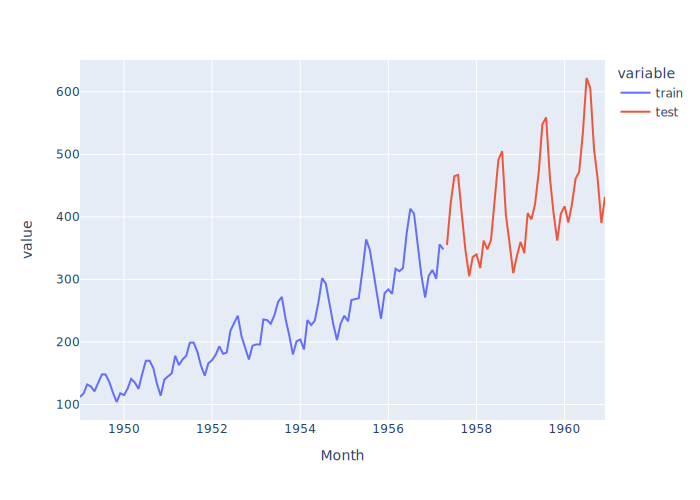

In [5]:
#r
pd.options.plotting.backend = "plotly"
fig = pd.DataFrame({'train': data_train, 'test': data_test}).plot()
fig.write_image('src/02_input.png', width=800*1.2, height=450*1.2)
fig

### Evaluate Model on Test Data

In [6]:
model = ARIMA(data_train, order=(0, 1, 2), seasonal_order=(1, 1, 1, 12)) #!
model_fit = model.fit()
y_pred_test = model_fit.forecast(len(data_test))
score_test = mean_squared_error(data_test, y_pred_test, squared=False)
score

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



12.487395495743867

### Evaluate Model on Train Data

In [7]:
y_pred_train = model_fit.predict() #!
score_train = mean_squared_error(data_train[1:], y_pred_train[1:], squared=False)
score_train

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



11.37028559033624

### Visualize Overfitting

In [8]:
pd.options.plotting.backend = "plotly"

data_train = data_train.rename('train')
data_test = data_test.rename('test')
y_pred_train = y_pred_train.rename('train_forecast_sarima')
y_pred_test = y_pred_test.rename('test_forecast_sarima')

df_pred = pd.concat([data_train, data_test, y_pred_train, y_pred_test], axis=1)

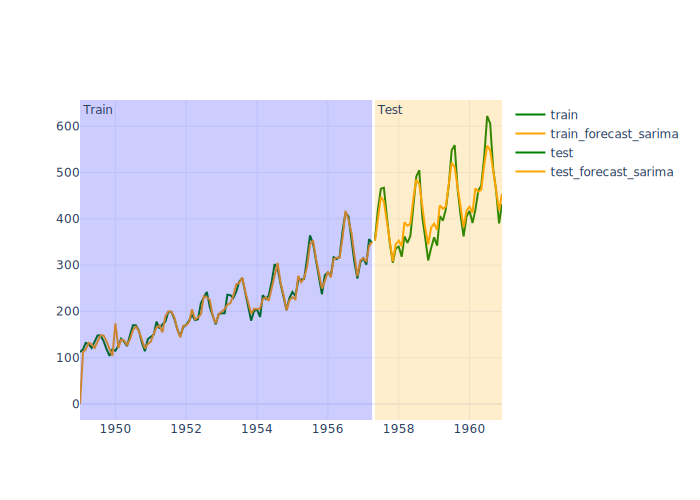

In [9]:
#r

import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train, name='train', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=y_pred_train.index, y=y_pred_train, name='train_forecast_sarima', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test, name='test', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=y_pred_test.index, y=y_pred_test, name='test_forecast_sarima', marker=dict(color='orange')))

fig.add_vrect(
    x0=data_train.index.min(), x1=data_train.index.max(),
    line_width=0, fillcolor='blue', opacity=0.2,
    annotation_text='Train', annotation_position="top left")

fig.add_vrect(
    x0=data_test.index.min(), x1=data_test.index.max(),
    line_width=0, fillcolor='orange', opacity=0.2,
    annotation_text='Test', annotation_position="top left")

fig.update_layout(template="plotly_white")
fig.write_image('src/02_output_1.png', width=800*1.2, height=450*1.2)
fig

## [ ] Model Comparison: SARIMA vs Exponential Smoothing

### Fit the Model

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(data_train, trend="add", seasonal="add", seasonal_periods=12)
model_fit = model.fit()

### Forecast: Calculate Predictions

In [11]:
data_forecast = model_fit.forecast(len(data_test))

df_pred['test_forecast_exponential'] = data_forecast
df_pred

,train,test,train_forecast_sarima,test_forecast_sarima,test_forecast_exponential
1949-01-01,112.0,NaN,0.00000,NaN,NaN
1949-02-01,118.0,NaN,111.99867,NaN,NaN
...,...,...,...,...,...
1960-11-01,NaN,390.0,NaN,418.207799,379.605076
1960-12-01,NaN,432.0,NaN,454.311865,417.035511


In [12]:
import plotly.graph_objects as go

In [13]:
df_pred_test = df_pred.filter(like='test').dropna()
df_pred_test

,test,test_forecast_sarima,test_forecast_exponential
1957-05-01,355.0,352.272795,351.239543
1957-06-01,422.0,406.086678,403.308153
...,...,...,...
1960-11-01,390.0,418.207799,379.605076
1960-12-01,432.0,454.311865,417.035511


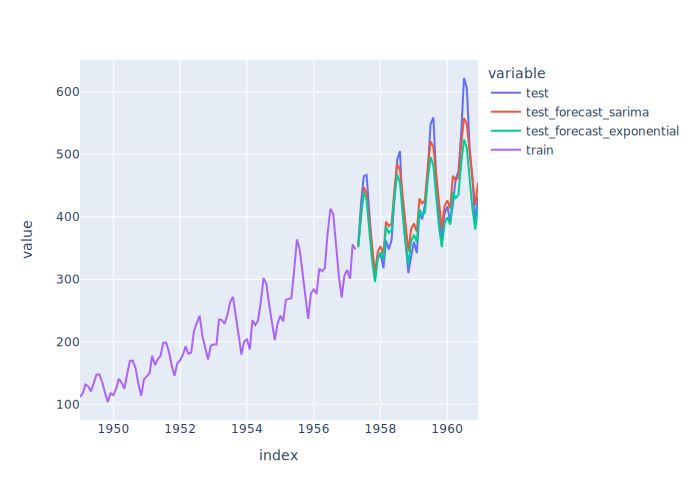

In [14]:
import plotly.graph_objects as go

fig = df_pred_test.plot()

fig.add_traces(
    go.Scatter(x=data_train.index, y=data_train, name="train")
)

In [15]:
#r

fig.write_image('src/02_output_2.png', width=800*1.2, height=450*1.2)

### Model's Score: Predictions vs. Reality

In [16]:
from sklearn.metrics import mean_squared_error

rmse_exponential = mean_squared_error(df_pred_test.test, df_pred_test.test_forecast_exponential, squared=False)
rmse_exponential

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



33.6291735577628

In [17]:
rmse_sarima = mean_squared_error(df_pred_test.test, df_pred_test.test_forecast_sarima, squared=False)
rmse_sarima

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



25.911990997475304